In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import mediapipe as mp
import numpy as np
import cv2 as cv2

In [2]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [3]:
# import zipfile
# with zipfile.ZipFile("train.zip","r") as zip_ref:
#     zip_ref.extractall("train")

In [4]:
train_dir = 'train/asl_alphabet_train/asl_alphabet_train'
test_dir = 'test/asl-alphabet-test'

In [5]:
STANDARD_HEIGHT = 200
STANDARD_WIDTH = 200
MIN_CONFIDENCE_LEVEL = 0.7

class MediaPipe(object):
    def __call__(self, sample):
#         import pdb; pdb.set_trace()
        image = np.array(sample)
        mp_hands = mp.solutions.hands
        with mp_hands.Hands(static_image_mode = True,max_num_hands = 2,
            min_detection_confidence = MIN_CONFIDENCE_LEVEL) as hands:

            #For training change this line, don't need to flip (since images appear to be from back-facing camera) 
            #Convert cv2 BGR image to RGB image and flip (since image coming from front-facing camera)  
            processed = hands.process(cv2.flip(image, 1))

            #No hand detected (Figure out how we want to handle, 126 vector with all 0s?): 
            if not processed.multi_hand_landmarks: 
                zeros = torch.tensor(np.array([0] * 126), dtype=torch.float32)
                return zeros

            feature_vector = [] 
            #Could have one or two hands: 
            for hand in processed.multi_hand_landmarks: 
                for curr_landmark in hand.landmark: 
                    x = curr_landmark.x 
                    feature_vector.append(x)

                    y = curr_landmark.y 
                    feature_vector.append(y)

                    z = curr_landmark.z
                    feature_vector.append(z)

            #If we have just one hand, zero out the remaining (to ensure constant vector size of 126)
            #Might cause problems in one-hand case if we care which hand is visible/showing sign language
            #Solution to this is to use processed.multi_handedness
            if (len(feature_vector) == 63):
                zero_vector = [0] * 63 
                feature_vector.extend(zero_vector)
            
            output = torch.tensor(np.array(feature_vector), dtype=torch.float32)

            return output



In [6]:
transform = transforms.Compose([
    MediaPipe(),
])
test_transform = transforms.Compose([
    transforms.Resize((200,200)),
    MediaPipe(),
])
dataset = ImageFolder(train_dir, transform=transform)
test = ImageFolder(test_dir, transform=test_transform)

In [7]:
dataset[6]

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


(tensor([ 2.7970e-01,  7.7219e-01, -1.7897e-06,  1.5134e-01,  6.7943e-01,
         -2.7918e-02,  7.9879e-02,  5.2470e-01, -4.5893e-02,  7.8037e-02,
          3.9787e-01, -6.8957e-02,  1.0990e-01,  2.9550e-01, -8.4862e-02,
          1.9695e-01,  4.0148e-01,  1.1828e-03,  1.6516e-01,  3.2843e-01,
         -6.9060e-02,  1.5181e-01,  4.3508e-01, -1.1256e-01,  1.5143e-01,
          5.3223e-01, -1.2950e-01,  2.8268e-01,  4.1856e-01, -1.3367e-02,
          2.3814e-01,  3.6513e-01, -8.9069e-02,  2.2481e-01,  4.9813e-01,
         -1.1013e-01,  2.2211e-01,  6.0418e-01, -1.0397e-01,  3.6469e-01,
          4.5183e-01, -3.8334e-02,  3.0737e-01,  4.1583e-01, -1.1127e-01,
          2.8970e-01,  5.4457e-01, -9.5069e-02,  2.8387e-01,  6.4001e-01,
         -6.1881e-02,  4.4483e-01,  4.9975e-01, -6.5776e-02,  3.8048e-01,
          4.7142e-01, -1.1261e-01,  3.5463e-01,  5.6246e-01, -9.3425e-02,
          3.4747e-01,  6.2949e-01, -6.3755e-02,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.

In [8]:
dataset_len = len(dataset)
train_len_proportion = 0.9
train_len = int(train_len_proportion * dataset_len)
val_len = dataset_len - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

In [9]:
len(train_dataset), len(val_dataset)

(78300, 8700)

In [10]:
batch_size = 50
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)

In [11]:
classes = dataset.classes
print(len(classes))

29


RuntimeError: number of dims don't match in permute

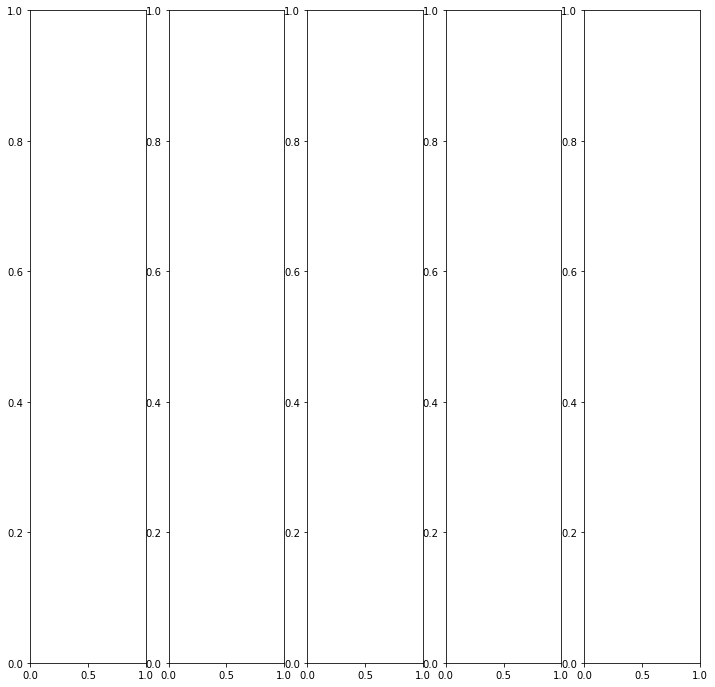

In [12]:
# iter_data = iter(train_dl)
# fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
# for i in range(5):
#     img, label = next(iter_data)
#     ax = axes[i]
#     ax.imshow(img[0].permute(1, 2, 0))
#     ax.title.set_text(''.join('%5s' % classes[label[0]]))
# plt.show()

In [25]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
            
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [26]:
device = get_default_device()
device

device(type='cuda')

In [27]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

In [28]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [29]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [30]:
class ASLResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(126, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 29),
        )
        
        self.network = self.linear_relu_stack
    
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
#         for param in self.network.fc.parameters():
#             param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [31]:
model = to_device(ASLResnet(), device)
model

ASLResnet(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=126, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=29, bias=True)
  )
  (network): Sequential(
    (0): Linear(in_features=126, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=29, bias=True)
  )
)

In [32]:
from tqdm import tqdm
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
history = [evaluate(model, valid_dl)]
history

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [07:57<00:00,  5.48s/it]


[{'val_loss': 3.36788272857666, 'val_acc': 0.03206896409392357}]

In [39]:
model.freeze()
epochs = 3
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [40]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [07:14<00:00,  4.99s/it]


Epoch [0], val_loss: 2.0145, val_acc: 0.4929


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [07:12<00:00,  4.97s/it]


Epoch [1], val_loss: 1.6586, val_acc: 0.5867


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [08:47<00:00,  6.07s/it]

Epoch [2], val_loss: 1.6139, val_acc: 0.6001
CPU times: user 37.6 s, sys: 8.25 s, total: 45.9 s
Wall time: 3h 49min 3s


In [41]:
torch.save(model.state_dict(), 'asl-colored-mediapipe-mvp2.pth')

In [42]:
### Test
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]
len(test)
test_dl = DataLoader(test, batch_size, num_workers=4, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)
evaluate(model, test_dl)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:36<00:00,  2.05s/it]


{'val_loss': 1.2204302549362183, 'val_acc': 0.6600000262260437}

In [46]:
# Sanity Check
model2 = to_device(ASLResnet(), device)
model2.load_state_dict(torch.load('checkpoints/asl-colored-mediapipe-mvp.pth'))
evaluate(model2, valid_dl)




  0%|                                                    | 0/87 [00:00<?, ?it/s]

  1%|▌                                           | 1/87 [00:00<00:59,  1.46it/s]

  2%|█                                           | 2/87 [00:01<00:41,  2.06it/s]

  3%|█▌                                          | 3/87 [00:01<00:35,  2.36it/s]

  5%|██                                          | 4/87 [00:01<00:32,  2.53it/s]

  6%|██▌                                         | 5/87 [00:02<00:31,  2.63it/s]

  7%|███                                         | 6/87 [00:02<00:29,  2.70it/s]

  8%|███▌                                        | 7/87 [00:02<00:29,  2.74it/s]

  9%|████                                        | 8/87 [00:03<00:28,  2.77it/s]

 10%|████▌                                       | 9/87 [00:03<00:27,  2.79it/s]

 11%|████▉                                      | 10/87 [00:03<00:27,  2.80it/s]

 13%|█████▍                                     | 11/87 [00:04<00:26,  2.82it/s]

 14%|█████▉   

{'val_loss': 0.001335574546828866, 'val_acc': 1.0}